# Maxi:
Comencé el programa haciendo las gráficas un poco al azar, representando todo porque no sabía qué necesitaría. Hay muchas gráficas que no sé si tienen mucha utilidad, ya que la verdad no les veo un propósito claro. A partir de la matriz de covarianza, logré darle un poco de dirección a las gráficas. Descarté la difusión general y la difusión debido a su baja correlación, y como los datos están correlacionados, decidí centrarme en el análisis de la temperatura. Una vez que tengamos alguna conclusión sobre la temperatura, podremos aplicarla al resto de las variables. Realicé un suavizado utilizando la media móvil y también con el suavizado gaussiano para ver si se apreciaba alguna tendencia. Además, dividí la gráfica en tres partes y ajusté curvas lineales y cuadráticas a cada una de ellas. Luego, hay otras gráficas por día debajo. Creo que a partir de aquí solo faltaría aplicar el mismo análisis a las variables de humedad y las zonas, y buscar correlaciones entre las curvas.

Creo que tengo aun dudas sobre el tipo de conclusiones que buscamos y algunos parametros que tome a ojo.

Se que quizas no este muy claro todo pero avisame si necesitas que te explique lo que hice, espero que sea tan claro como queria que quedara.

In [44]:
import numpy as np
import os
import csv, datetime
#from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [3]:
# voy al direcotrio desde donde voy a trabajar
os.chdir('/home/ludeu/Escritorio/MachineLearning/Data/proyecto/power-consumption')

#creo mi path
archivo = os.path.join("..", "power-consumption","powerconsumption.csv")

#leo el archivo y guardon en data
with open(archivo,"r") as fp:
    reader = csv.reader(fp, delimiter=",")
    data = []
    for row in reader:
        data.append(row)

data = data[1:]

#creo un diccionario para manipular mejor mi archivo
data_dicc = {'TIME': [],
             'TEMP': [],
             'HUM': [],
             'VEL_VIENTO': [],
             'DIFU_GENERAL': [],
             'DIFU': [],
             'CONSUM_ZONA1': [],
             'CONSUM_ZONA2': [],
             'CONSUM_ZONA3': []
             }

cont_menos_datos = 0

for fila in data:
    if len(fila) > 8:
        data_dicc['TIME'].append(datetime.datetime.strptime(fila[0],'%m/%d/%Y %H:%M'))
        data_dicc['TEMP'].append(float(fila[1]))
        data_dicc['HUM'].append(float(fila[2]))
        data_dicc['VEL_VIENTO'].append(float(fila[3]))
        data_dicc['DIFU_GENERAL'].append(float(fila[4]))
        data_dicc['DIFU'].append(float(fila[5]))
        data_dicc['CONSUM_ZONA1'].append(float(fila[6]))
        data_dicc['CONSUM_ZONA2'].append(float(fila[7]))
        data_dicc['CONSUM_ZONA3'].append(float(fila[8]))
    else:
        cont_menos_datos += 1 

# como vemos por cont_menos_datos no hay casillas vacias

#convierto los datos en un array y el tiempo en otro

claves = [clave for clave in data_dicc if clave != 'TIME']

arrays_columnas = [np.array(data_dicc[clave]) for clave in claves]

datos = np.column_stack(arrays_columnas)
time = data_dicc['TIME']


In [16]:
datos[1,:]
print(datos.shape,52416/144)

(52416, 8) 364.0


In [17]:
#verificamos que estes equiespaciados:
from collections import Counter
espaciado = [time[i+1]-time[i] for i in range(len(time)-1)]

Counter(espaciado)
#estan espaciados todos po 10min

Counter({datetime.timedelta(seconds=600): 52415})

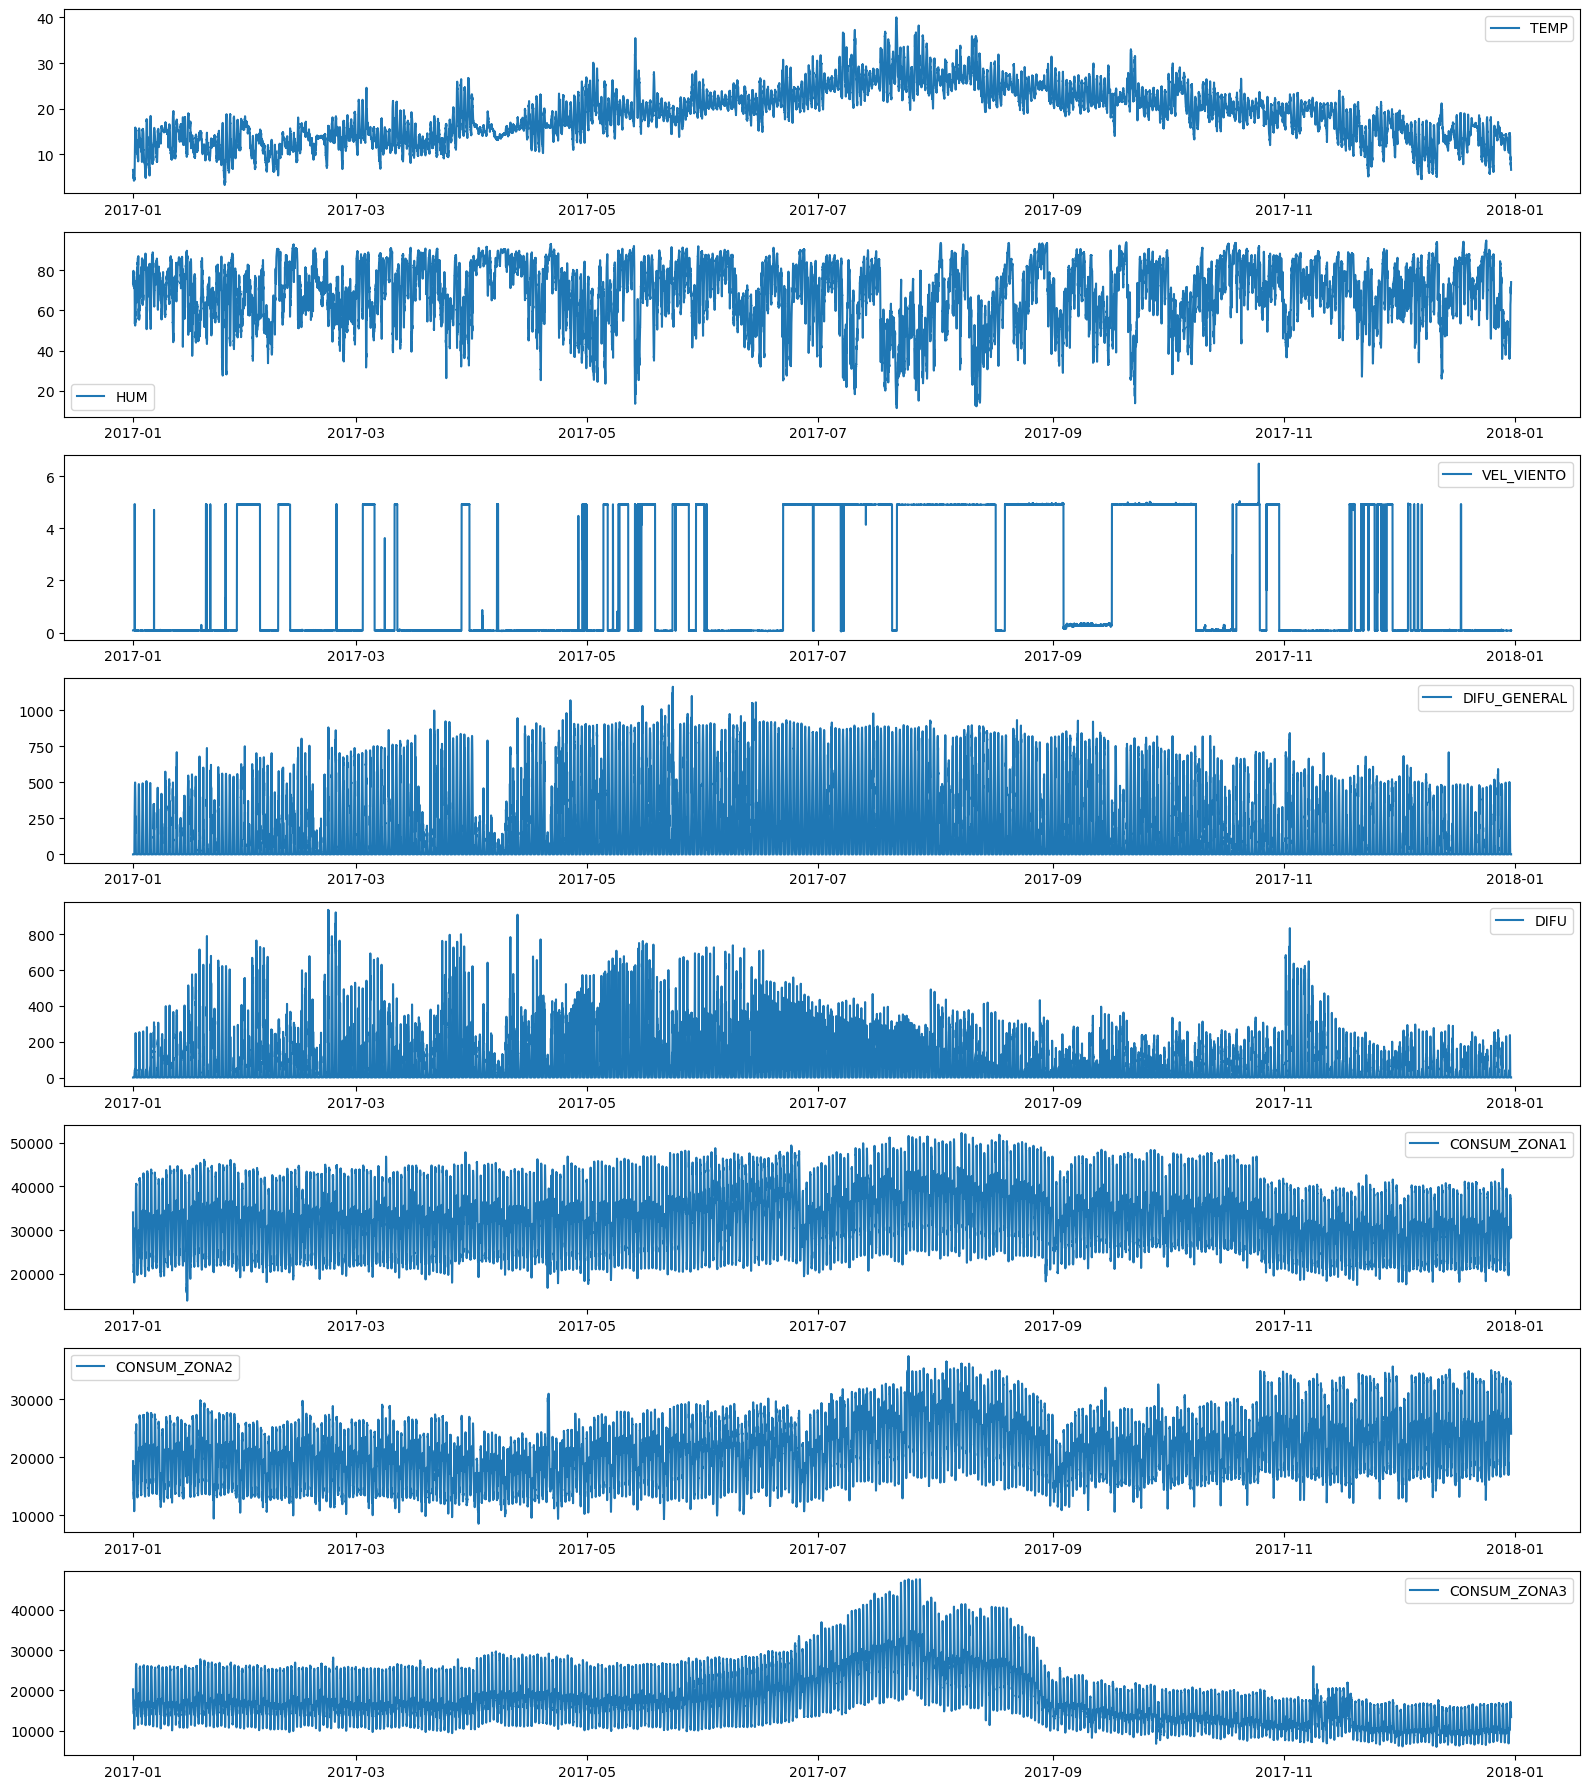

In [18]:
#graficamos datos crudos

fig, axs = plt.subplots(datos.shape[1],1, figsize=(16,18))
for i in range(datos.shape[1]):
    axs[i].plot(time, datos[:,i],'-', label=claves[i])
    axs[i].legend()
fig.tight_layout()


In [19]:
time_arr = np.array(time)
print(time_arr[:144*6:144].astype(str),time_arr.shape)

['2017-01-01 00:00:00' '2017-01-02 00:00:00' '2017-01-03 00:00:00'
 '2017-01-04 00:00:00' '2017-01-05 00:00:00' '2017-01-06 00:00:00'] (52416,)


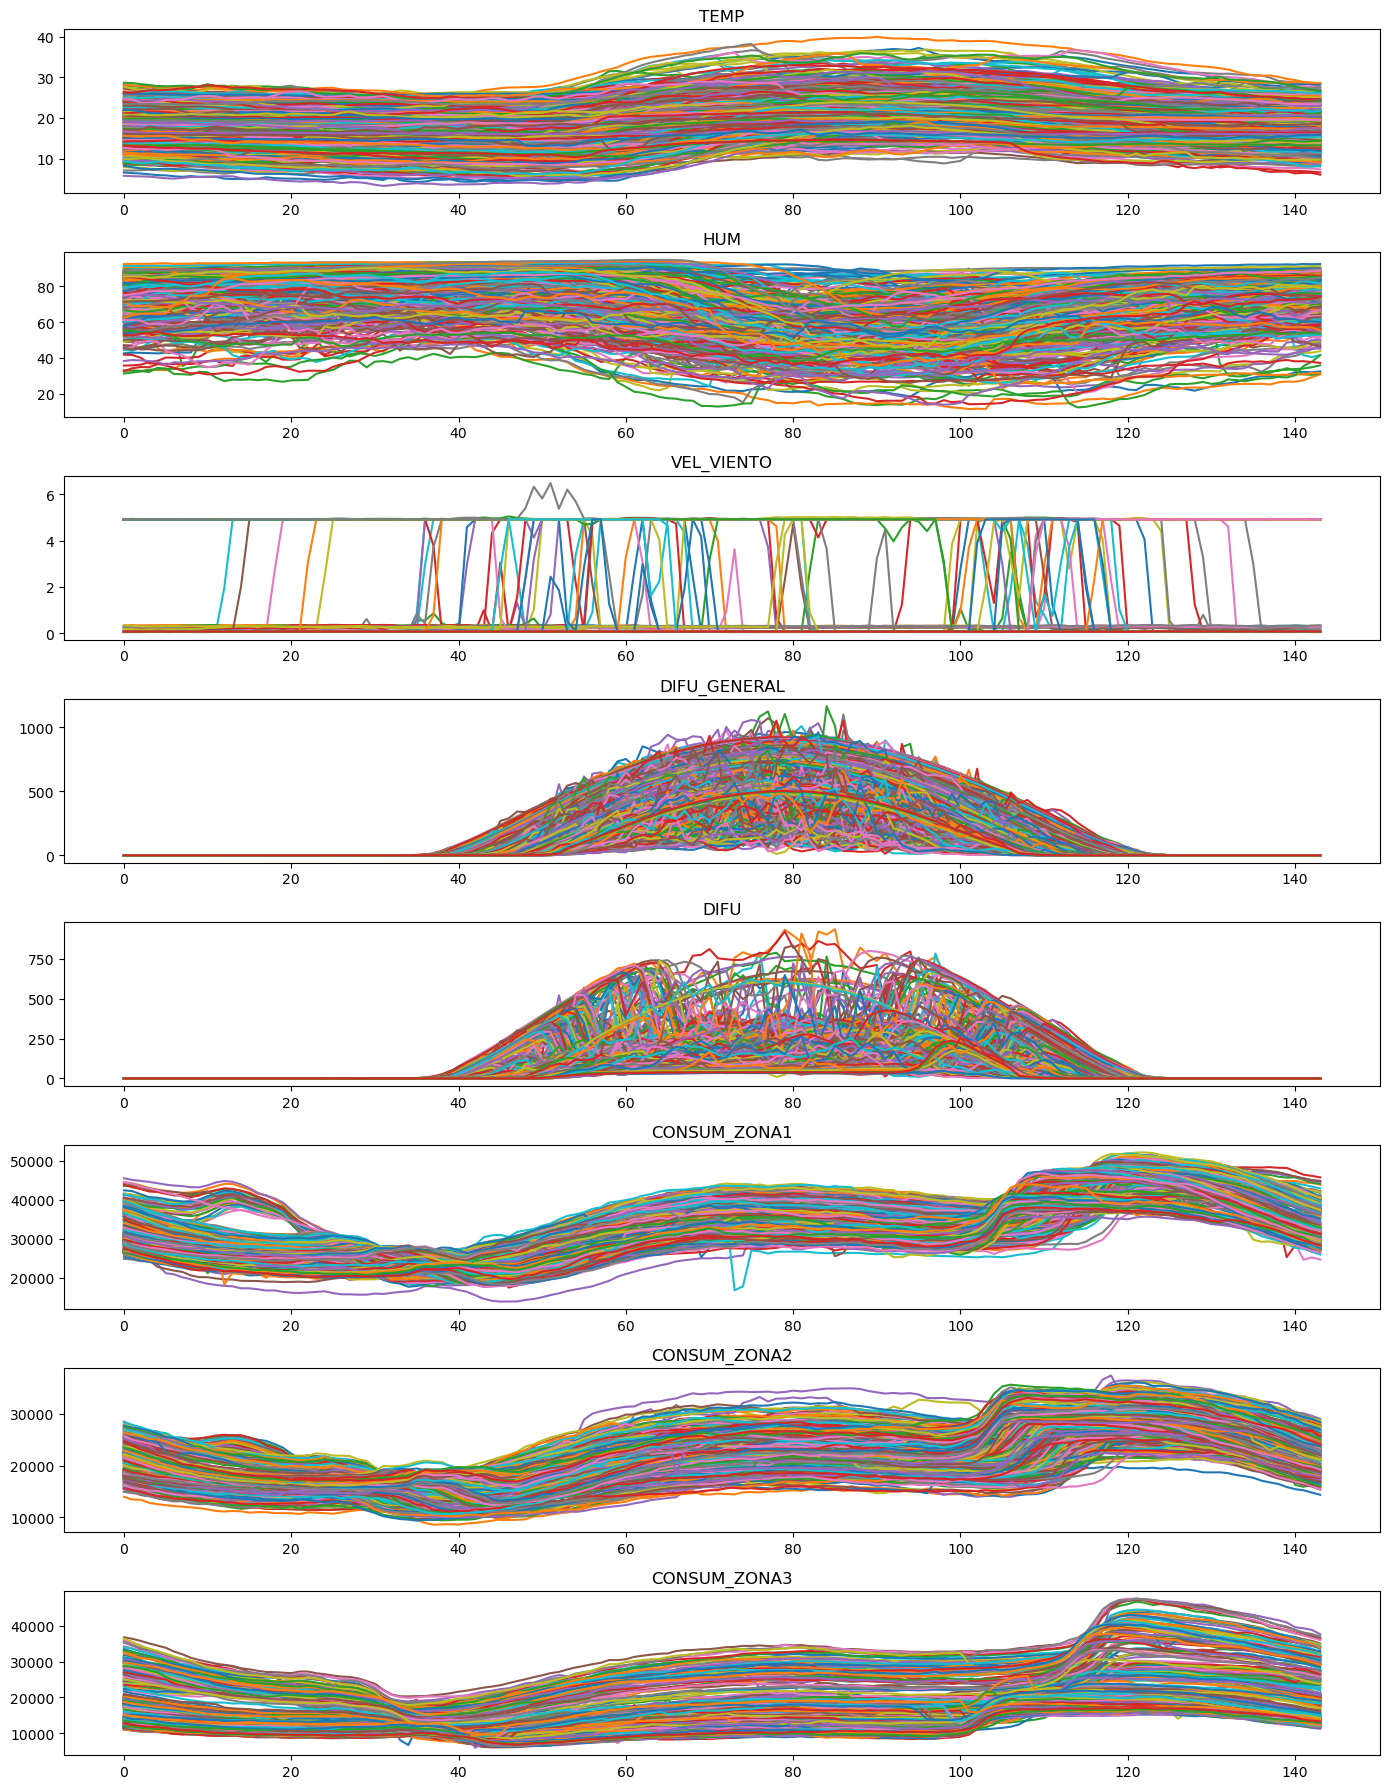

In [20]:
# graficamos datos cada 24 hs:

fig, axs = plt.subplots(8,1, figsize=(14,18))

for i in range(8):
    for j in range(len(time_arr)//144):
        axs[i].plot(datos[j*144:(j+1)*144,i], '-')
    axs[i].set_title(claves[i])
fig.tight_layout()

#MAXI: hay que cambiar el 'eje x' por cantidad de minutos.

In [35]:
# esto es para mi, ver cuantos datos por mes
60*24*30/10
time_arr[::4320].astype(str)
time_arr[-1]

datetime.datetime(2017, 12, 30, 23, 50)

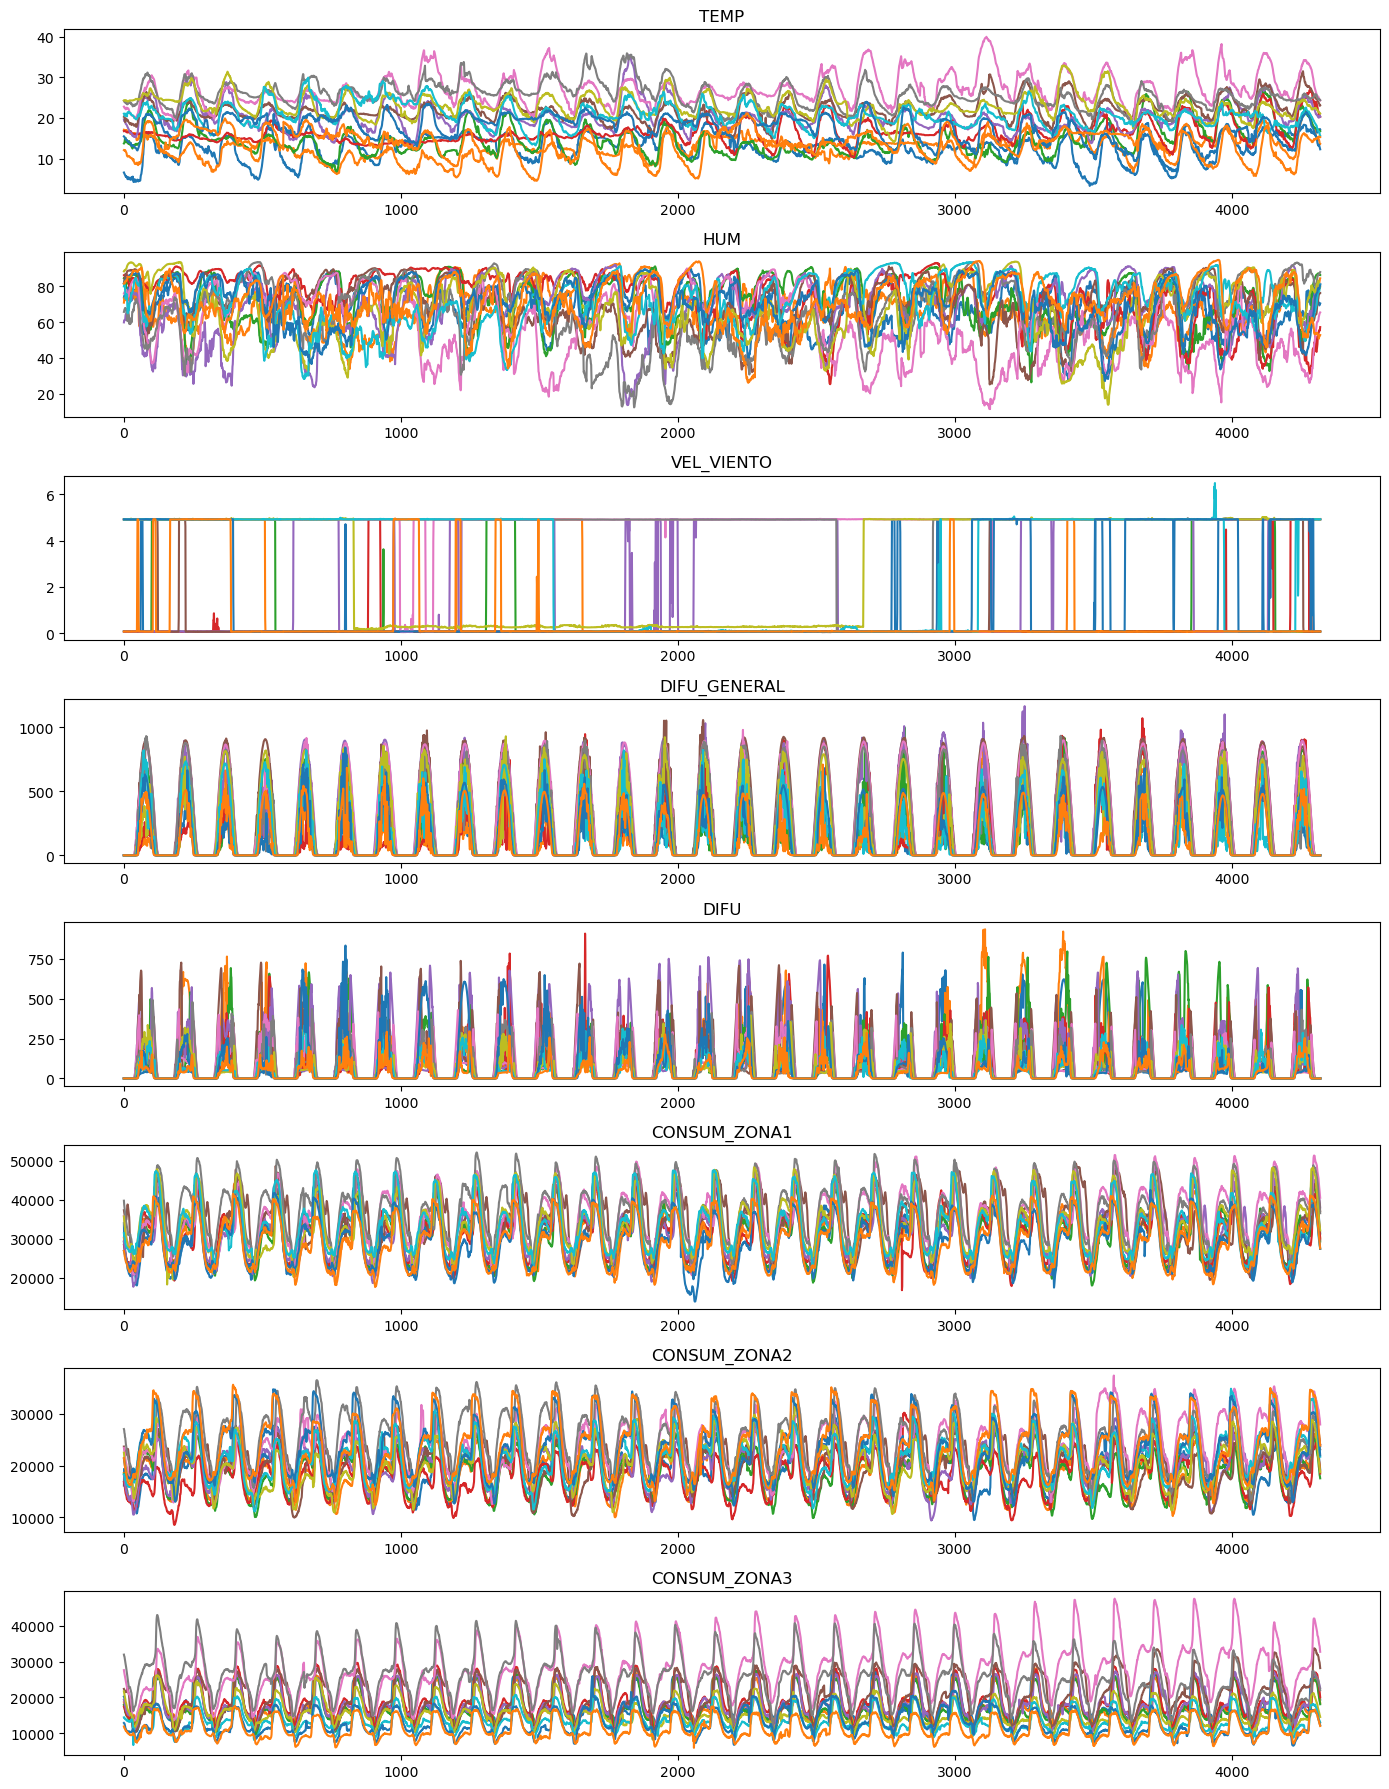

In [22]:
# graficamos datos cada mes:

fig, axs = plt.subplots(8,1, figsize=(14,18))

for i in range(8):
    for j in range(len(time_arr)//4320):
        axs[i].plot(datos[j*4320:(j+1)*4320,i], '-')
    axs[i].set_title(claves[i])
fig.tight_layout()
#MAXI : poner unidades en las graficas, no entiendo de que tratan
#los ejes y tambien para que ya queden hechas las figuras



In [ ]:
#con estos analisis podemos la mayoria de las variables son estacionarios y podemos calcular alguna relacion entre ellos

# Matriz de Correlacion

de las graficas por dia podemos inferir que no todas las variables tienen una correlacion. Vamos a hacer el analisis en base a aquellos datos que se relacionen con los consumos de las zonas. Con este fin vamos a crear una matriz de correlacion para descartar los datos menos importantes.

https://medium.datadriveninvestor.com/time-series-forecasting-of-power-consumption-values-using-machine-learning-4dcd2a59cfee


## coeficiente de correlacion
El coeficiente de correlación de Pearson mide la relación lineal entre dos conjuntos de datos. Varía entre -1 y +1, donde:\
0 implica ninguna correlación.\
1 indica una correlación positiva perfecta (si una variable aumenta, la otra también lo hace).\
-1 indica una correlación negativa perfecta (si una variable aumenta, la otra disminuye).\
Es una medida comúnmente utilizada para evaluar cómo dos variables se mueven juntas.

el metodo que vamos a usar tambien nos devuelve un valor de la prueba de la hipotesis nula, una prueba de hipótesis nula se utiliza para evaluar si el coeficiente de correlación entre dos variables es significativamente diferente de cero: Si el valor p resultante de la prueba es menor que el nivel de significancia (por ejemplo, 0.05), rechazamos la hipótesis nula.\
En otras palabras, si el valor p es bajo, concluimos que hay evidencia suficiente para afirmar que existe una correlación significativa entre las variables.\
En resumen, la prueba de hipótesis nula nos ayuda a determinar si el coeficiente de correlación observado en la muestra es estadísticamente significativo o simplemente debido al azar.

MAXI:

*Correlación positiva fuerte: Valores cercanos a 1 indican una correlación positiva fuerte. Por ejemplo, un valor de 0.8 o más sugiere una correlación positiva bastante fuerte.\
*Correlación positiva moderada: Valores entre 0.5 y 0.8 sugieren una correlación positiva moderada. Indican que hay una relación positiva entre las variables, pero no es tan fuerte como en el caso anterior.\
*Correlación débil o inexistente: Valores cercanos a 0 indican una correlación débil o inexistente entre las variables. Esto sugiere que no hay una relación lineal clara entre las dos variables.


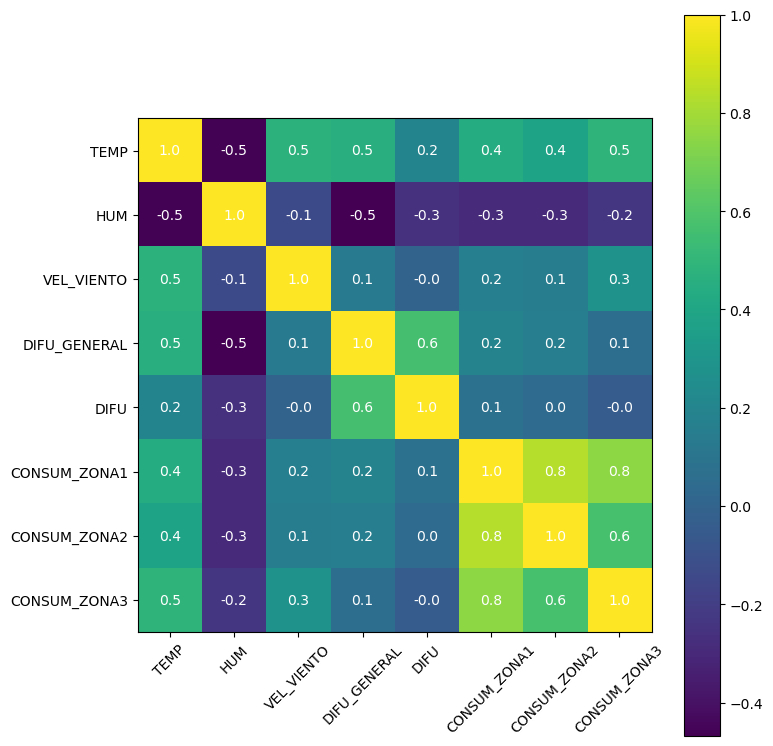

[[0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.8 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.8 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]]


In [4]:
#calculamos la matriz de correlaciones entre las vaiables

mtx_corr = [] #matriz de correlacion
mtx_pv = []   #matriz de prueba de la hipotesis nula
for i in range(8):
    fila_corr = []
    fila_pv = []
    for j in range(8):
        r, p = pearsonr(datos[:,i],datos[:,j])
        fila_corr.append(r)
        fila_pv.append(p)
    mtx_corr.append(fila_corr)
    mtx_pv.append(fila_pv)
mtx_corr = np.array(mtx_corr)
mtx_pv = np.array(mtx_pv)

#print(mtx_corr, mtx_pv)

#Graficamos un mapa de calor
fig, axs = plt.subplots(figsize=(8,8))
im = axs.imshow(mtx_corr)

axs.set_xticks(np.arange(len(claves)))
axs.set_yticks(np.arange(len(claves)))
axs.set_xticklabels(claves, rotation=45)
axs.set_yticklabels(claves)

#escribimos los datos en los cuadrados
for i in range(8):
    for j in range(8):
        text = axs.text(j, i, np.round(mtx_corr[i, j], decimals=1), ha="center", va="center", color="w")
plt.colorbar(im)
fig.tight_layout()
plt.show()

print(np.round(mtx_pv, decimals=1))

La matriz de correlación creada muestra la correlación única entre cada característica con otras características en el conjunto de datos.
Si 2 variables se correlacionan entre sí por:
0,0 a 0,3, están débilmente correlacionados,
0,3 a 0,6, están moderadamente correlacionados,
0,6 a 0,9, están fuertemente correlacionados,
Finalmente, 0,9, están muy fuertemente correlacionados

Del análisis de las correlaciones entre las entre las variables se puede inferir: la temperatura se correlaciona moderadamente positivamente con todos los valores de consumo de energía y la humedad muestra una débil correlación negativa con el consumo de energía de las tres zonas. Las otras variables no se correlacionan significativamente con los valores de consumo de energía por lo que no necesitan atención como tal y se eliminarán más adelante en el modelo.

# Derivadas locales:

El análisis de derivadas locales en el contexto de series temporales puede proporcionar información valiosa sobre las tendencias y cambios en los datos a lo largo del tiempo. Aquí te explico cómo puede ser útil:

Detección de cambios abruptos:
Al calcular las derivadas locales (primeras o segundas), puedes identificar puntos donde la serie temporal experimenta cambios bruscos en su pendiente.
Estos cambios pueden indicar eventos significativos, como picos o valles, que pueden ser relevantes para tu análisis.

Identificación de tendencias:
Las derivadas locales pueden ayudarte a detectar tendencias ascendentes o descendentes en la serie.
Si la derivada es positiva, sugiere un aumento en los valores; si es negativa, indica una disminución.

Estimación de velocidad de cambio:
La magnitud de la derivada local proporciona información sobre la velocidad a la que los valores de la serie están cambiando.
Por ejemplo, una derivada grande indica un cambio rápido, mientras que una derivada pequeña sugiere un cambio gradual.

Suavizado de ruido:
Calcular derivadas locales puede ayudar a eliminar el ruido o fluctuaciones pequeñas en los datos.
Al suavizar la serie, puedes enfocarte en las tendencias subyacentes.

Análisis de estacionalidad:
Las derivadas locales también pueden revelar patrones estacionales.
Por ejemplo, si observas picos en las derivadas en ciertos momentos del año, podrías estar identificando estacionalidad.


In [5]:
#limpieza de datos: vamos a quitar las varialbes que no nos interesan, que estan en las culumnas 2,3 y 4.

if len(claves)==8:
    claves = claves[:2] + claves[5:]
    datos = np.concatenate((datos[:,:2],datos[:,5:]), axis=1)
else:
    print("los datos podrian estar filtrados ya")
print(claves,datos.shape)


['TEMP', 'HUM', 'CONSUM_ZONA1', 'CONSUM_ZONA2', 'CONSUM_ZONA3'] (52416, 5)


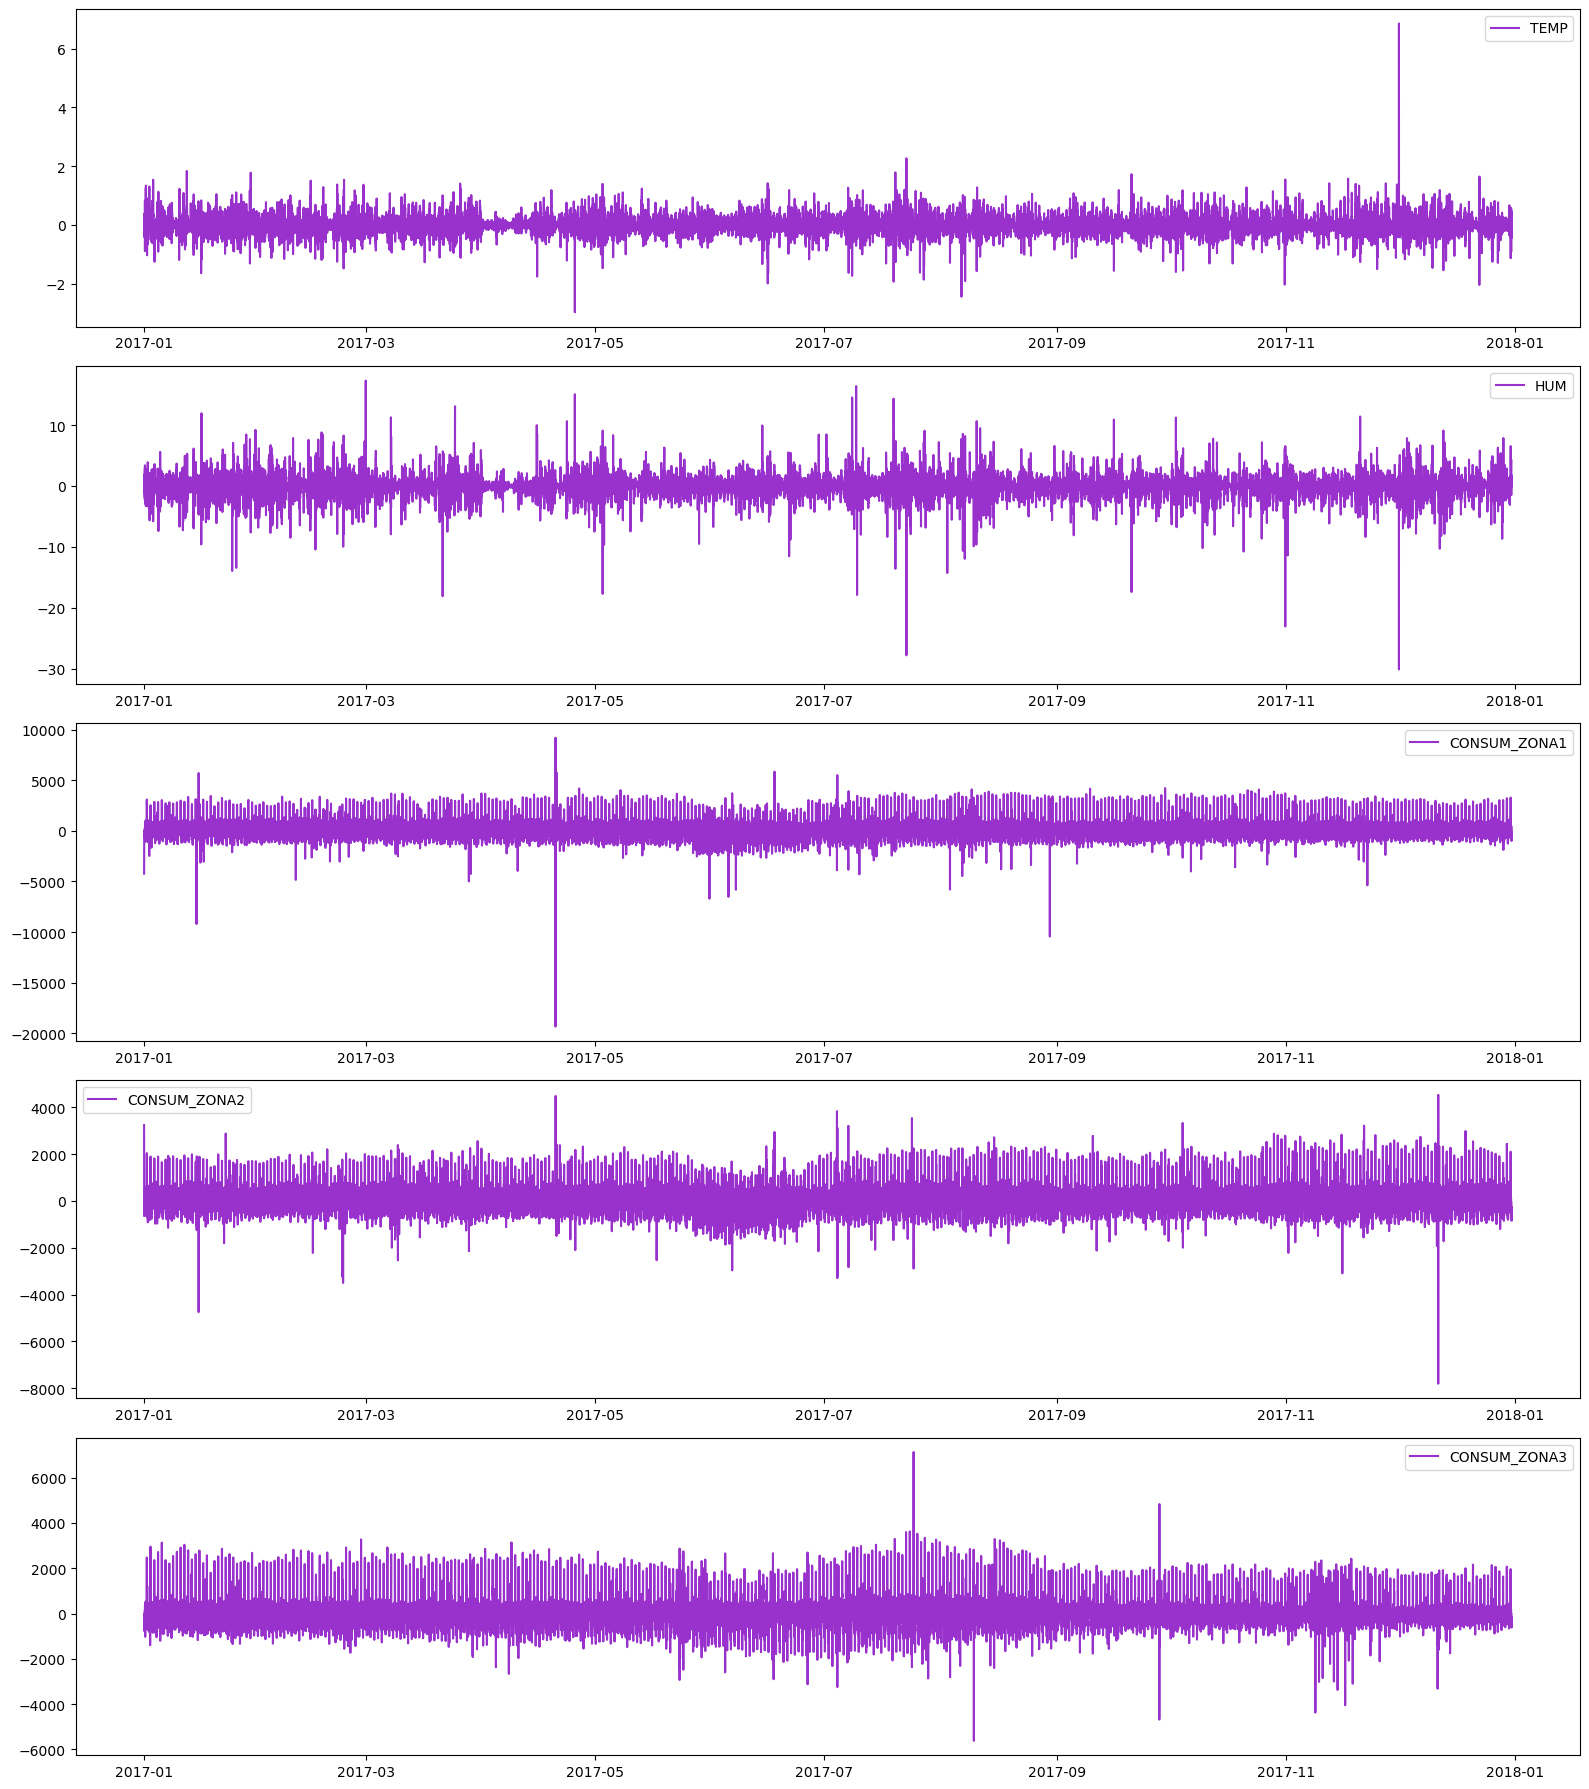

In [6]:
# analisis de cambios locales (derivadas)
def dif_fin(x,t):
    assert len(x) == len(t) , "las listas deben tener el mismo tamaño" 
    tam = len(x)
    x_d = (x[1:tam]-x[:tam-1])/(t[1:tam]-t[:tam-1])
    return x_d

#la definicion necesita dos listas o arrays, creo una lista con los tiempos en minutos, como sabes que estan
# espaciados por 10 minutos, creamos un array:

time2 = np.arange(0,52416)

#creamos la derivada y graficamos:

fig, axs = plt.subplots(datos.shape[1],1, figsize=(16,18))
for i in range(datos.shape[1]):
    axs[i].plot(time[1:], dif_fin(datos[:,i],time2), '-', label=claves[i], color="darkorchid")
    axs[i].legend()
fig.tight_layout()


# Media movil

$$ Sm[X(t_i)] = \sum_{r=-q}^{s} {a_r X(t_{i+r})} $$

La inspección de la media móvil sobre anchos diferentes puede servir para descartar oscilaciones y su ajuste para extraer la tendencia global, o por tramos.

Vamos a hacerlo sobre temperatura y luego relacionaremos con los otros

In [13]:
#analisis de media movil
def med_mov(t, x, paso):
    assert paso%2 == 1, 'el paso debe ser debe ser entero e impar' 
    n_saltos = x.shape[0]
    n_ventanas = n_saltos-paso
    tstamps = []
    y = np.zeros(n_ventanas)
    for i in range(0, n_ventanas):
        derch = n_saltos - i 
        izq = n_saltos - i - paso 
        y[n_ventanas - i - 1] = x[izq:derch].mean() 
        tstamps.insert(0,t[(izq+derch)//2])
    return tstamps, y


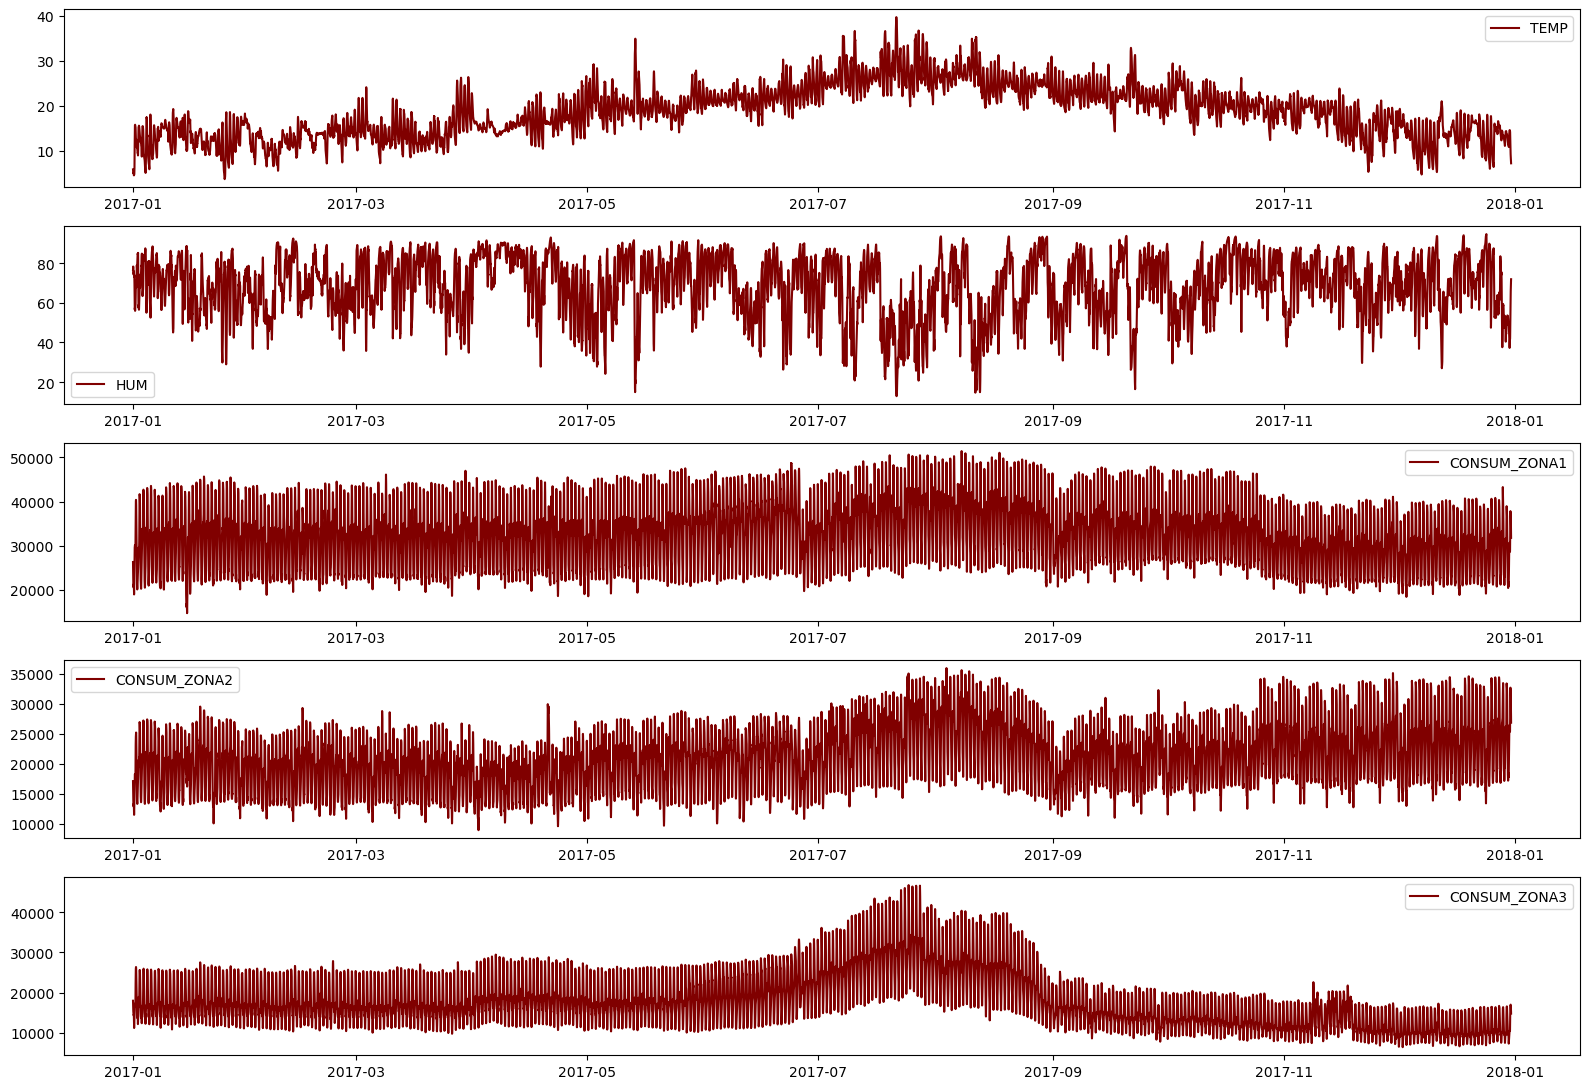

In [7]:
#graficamos las medias moviles cambiando ventanas
ws=11

fig, axs = plt.subplots(datos.shape[1],1, figsize=(16,11))
for i in range(datos.shape[1]):
    t, x = med_mov(time, datos[:,i], ws)
    axs[i].plot(t, x, '-', label=claves[i], color="maroon")
    axs[i].legend()
fig.tight_layout()


podemos ver un aumento en la tendencia en las temperaturas y los consumos, entre los meses 6 y 8, una disminucion entre los meses 9 al 11.
podriamos inferir que se trata de cambios por estaciones, etonces vamos a la temperatura para las 4 estaciones

In [9]:
#vamos a cortar y volver a graficar los datos pero solo para la temperatura:
#vamos a dividir el año en 4 estaciones, son 13104 datos
#sobran 10 dias del verano siguiente que voy a ignorar

estac =["Verano", "Primavera", "Invierno", "Otoño"]

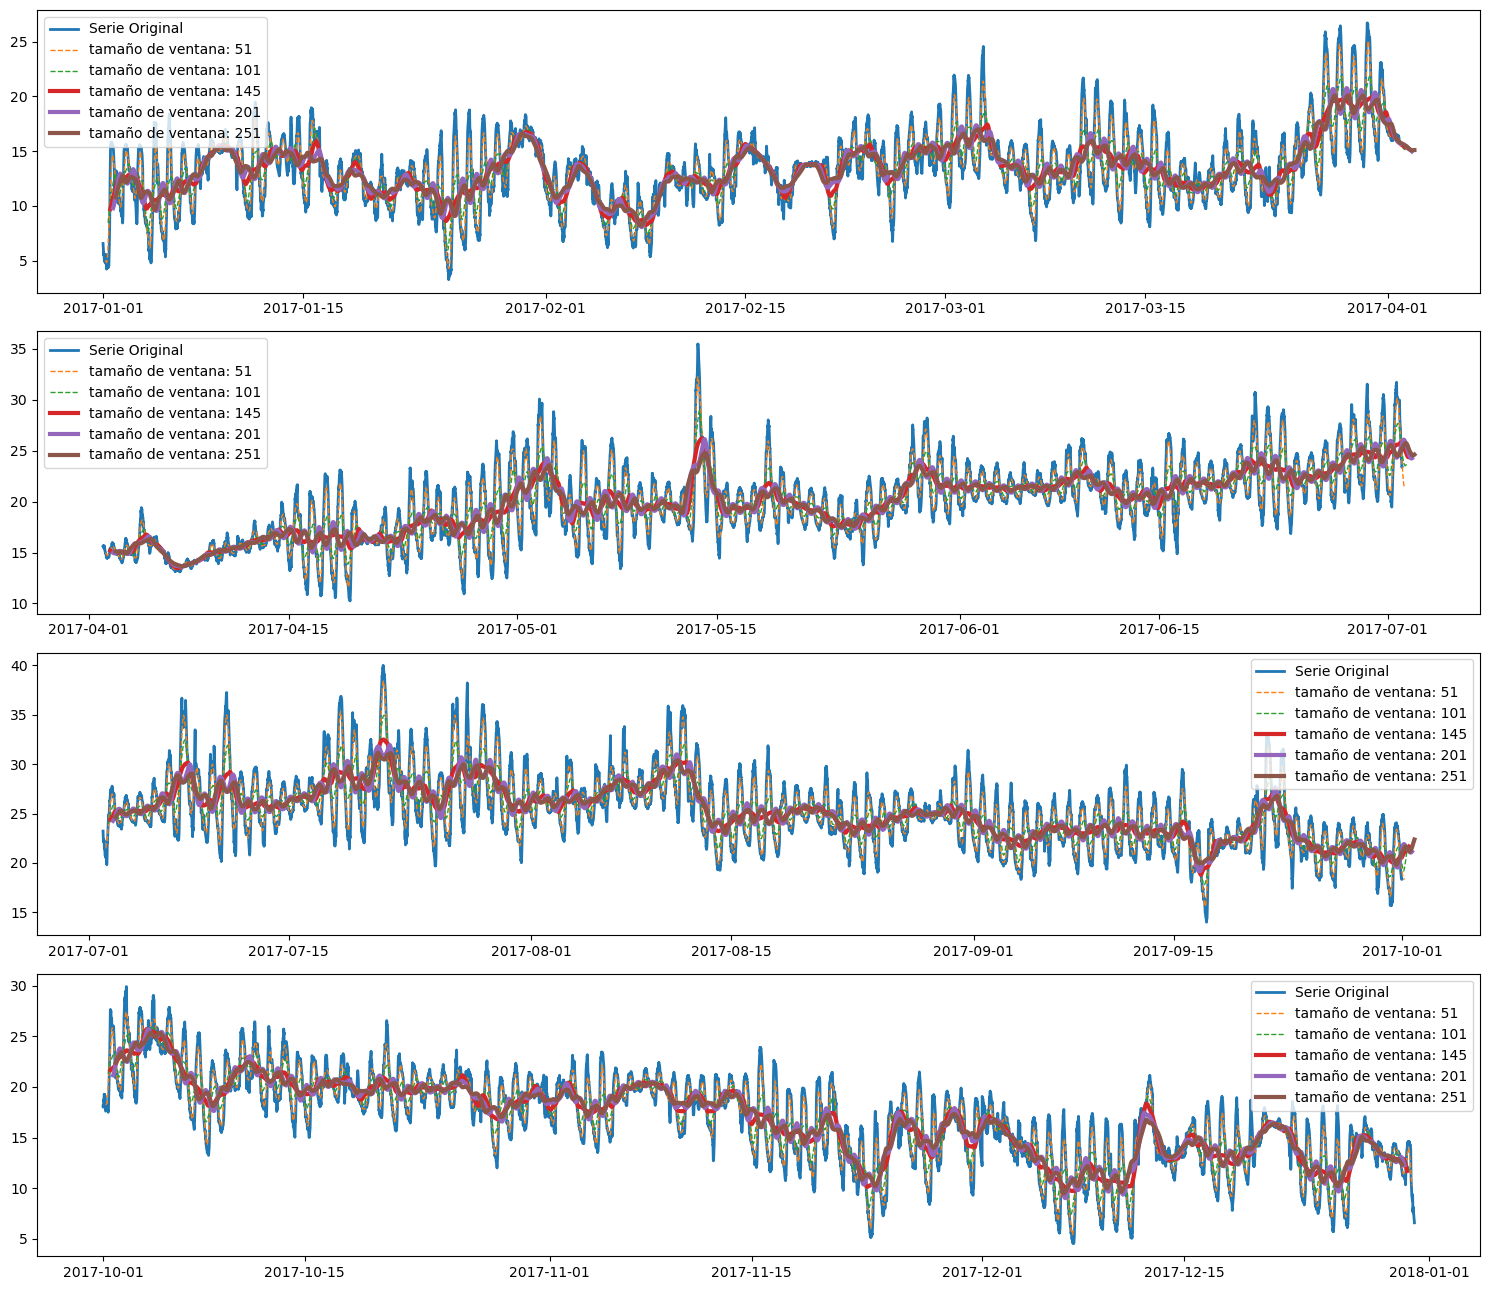

In [10]:
#graficamos temperatura en sus 4 estaciones 

fig, axs = plt.subplots(4,1, figsize=(15,13))

for i in range(4):
    axs[i].plot(time[i*13104:(i+1)*13104], datos[i*13104:(i+1)*13104,0], label = 'Serie Original', lw = 2)

for j in [51,101,145,201,251]:
    t, m = med_mov(time, datos[:,0], j)
    llw = 1
    ls = 'dashed'
    if j >= 145:
        llw = 3
        ls = 'solid'
    for i in range(4):
        axs[i].plot(t[i*13104:(i+1)*13104], m[i*13104:(i+1)*13104], lw = llw, linestyle= ls, label = f'tamaño de ventana: {j}')
        axs[i].legend()
    
fig.tight_layout()


# pregunta

como se cual es la mejor ventana?

observamos si la dispersión de los datos es aditiva o multiplicativa. Para ello utilizaremos la desviación estándar de los datos en ventanas móviles, de modo que se pueda observar su variación en el tiempo. Utilizaremos una ventana de 1 semana (porque quedo mas lindo cuando probe), ya que muestra la tendencia de modo más suave

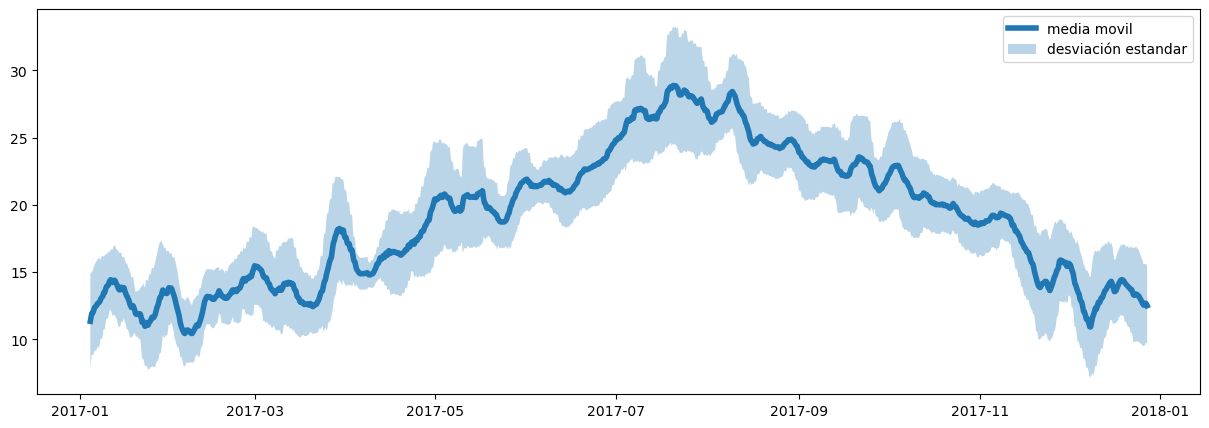

In [17]:
def std_mov(t, x, paso):
    assert paso%2 == 1, 'el paso debe ser debe ser entero e impar' 
    n_saltos = x.shape[0]
    n_ventanas = n_saltos-paso
    tstamps = []
    y = np.zeros(n_ventanas)
    for i in range(0, n_ventanas):
        derch = n_saltos - i 
        izq = n_saltos - i - paso 
        y[n_ventanas - i - 1] = x[izq:derch].std() 
        tstamps.insert(0,t[(izq+derch)//2])
    return tstamps, y

ws = 144*7+1
t_25, m_25 = med_mov(time, datos[:,0], ws)
t_25, std_25 = std_mov(time, datos[:,0], ws)

plt.figure(figsize=(15,5))
#plt.plot(time, datos[:,0], linestyle = 'dashed', label = 'Serie Original')
plt.plot(t_25, m_25, lw = 4, linestyle= 'solid', label = f'media movil')
plt.fill_between(t_25, m_25-std_25, m_25+std_25, alpha = 0.3, label = 'desviación estandar')
plt.legend(fontsize = 10)
plt.show()

# Suavizado gaussino

 $$ f(x) = a \cdot e^{-\frac{(x - b)^2}{2c^2}} $$

En el caso de que a sea igual $$  a = {\displaystyle \textstyle {\frac {1}{c{\sqrt {2\pi }}}}} $$, la función de densidad de una variable aleatoria corresponde con la distribución normal de media μ = b y varianza σ2 = c^2.

vamos a hacer la convolucion de la temperatura con la funcion gaussina para hacer el suavizado gaussiano

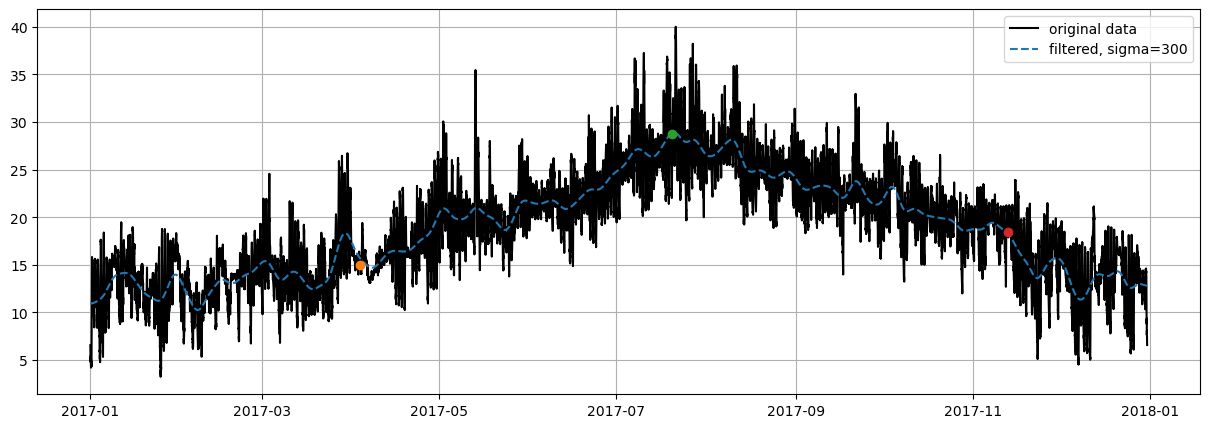

In [42]:
from scipy.ndimage import gaussian_filter1d

gauss = gaussian_filter1d(datos[:,0], 300)

plt.figure(figsize=(15,5))
plt.plot(time, datos[:,0], 'k', label='original data')
plt.plot(time, gauss, '--', label='filtered, sigma=300')
plt.plot(time[13392], datos[13392,0], "o")
plt.plot(time[28872], datos[28872,0], "o")
plt.plot(time[45504], datos[45504,0], "o")

plt.legend()
plt.grid()

# Tendecia

fiteamos la funcion temperatura funcion lineal y otra cuadatica

In [55]:
def lineal(x, a, b):
    return a*x + b

def cuadratica(x,a,b,c):
    return a*x**2 + b*x + c

(13392,)
[array([[ 5.06589436e-11, -3.39186959e-07],
       [-3.39186959e-07,  3.02814812e-03]]), array([[ 3.09274687e-11, -6.53543799e-07],
       [-6.53543799e-07,  1.44279574e-02]]), array([[ 2.24483496e-11, -8.34798006e-07],
       [-8.34798006e-07,  3.15615293e-02]])]


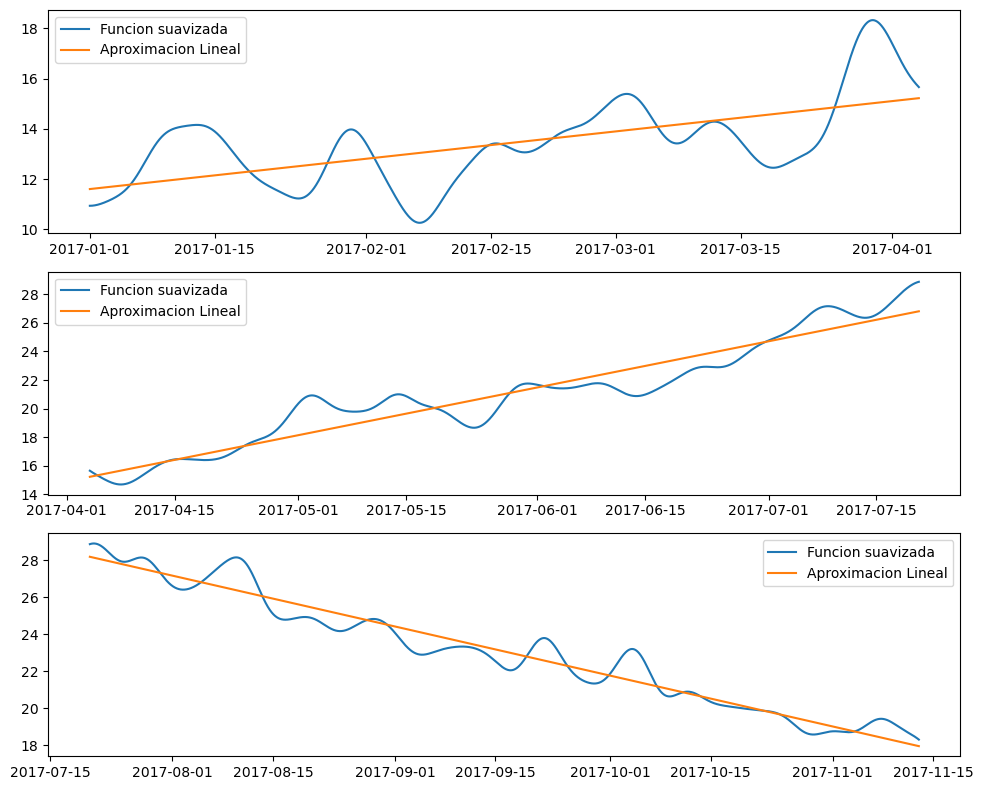

In [69]:
#Graficamos los tres trozos y fiteamos con curva lineal

mx_cov = []
corte = []
corte.append([i<13392 for i in range(len(time))])
corte.append([13392<= i <28872 for i in range(len(time))])
corte.append([28872<= i <45504 for i in range(len(time))])
print(datos[corte[0],0].shape)

time2 = np.arange(0,52416)
time_arr = np.array(time)

fig, axs = plt.subplots(3, 1, figsize=(10,8))
for i in range(3):
    param, m_cov = curve_fit(lineal,time2[corte[i]], datos[corte[i],0])
    mx_cov.append(m_cov)
    axs[i].plot(time_arr[corte[i]],gauss[corte[i]], label = "Funcion suavizada")
    axs[i].plot(time_arr[corte[i]],lineal(time2[corte[i]],*param), label = "Aproximacion Lineal")
    axs[i].legend()
fig.tight_layout()

print(mx_cov)

(13392,)
[array([[ 4.13032601e-18, -5.53091954e-14,  1.23431687e-10],
       [-5.53091954e-14,  7.90029167e-10, -1.98352252e-06],
       [ 1.23431687e-10, -1.98352252e-06,  6.64058545e-03]]), array([[ 1.92565838e-18, -8.13840992e-14,  8.21430186e-10],
       [-8.13840992e-14,  3.47029924e-09, -3.53661737e-05],
       [ 8.21430186e-10, -3.53661737e-05,  3.64749637e-01]]), array([[ 1.20820293e-18, -8.98600932e-14,  1.64298467e-09],
       [-8.98600932e-14,  6.70562559e-09, -1.23025565e-04],
       [ 1.64298467e-09, -1.23025565e-04,  2.26555262e+00]])]


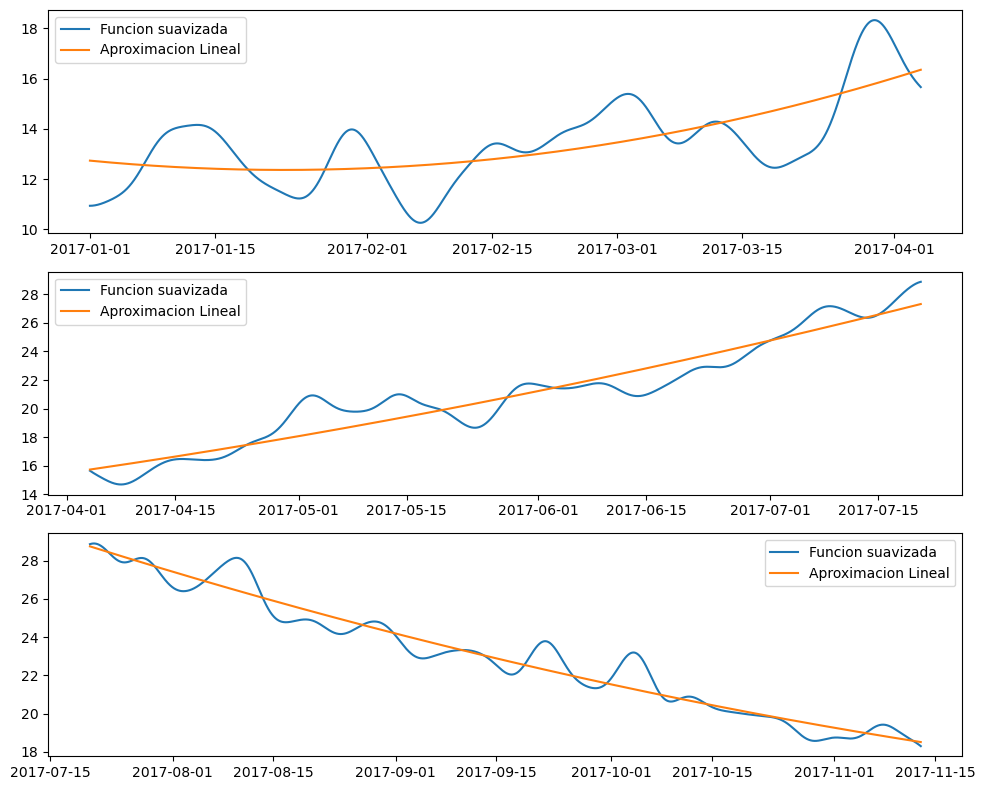

In [71]:
#Graficamos los tres trozos y fiteamos con curva cuadratica

mx_cov = []
corte = []
corte.append([i<13392 for i in range(len(time))])
corte.append([13392<= i <28872 for i in range(len(time))])
corte.append([28872<= i <45504 for i in range(len(time))])
print(datos[corte[0],0].shape)

time2 = np.arange(0,52416)
time_arr = np.array(time)

fig, axs = plt.subplots(3, 1, figsize=(10,8))
for i in range(3):
    param, m_cov = curve_fit(cuadratica,time2[corte[i]], datos[corte[i],0])
    mx_cov.append(m_cov)
    axs[i].plot(time_arr[corte[i]],gauss[corte[i]], label = "Funcion suavizada")
    axs[i].plot(time_arr[corte[i]],cuadratica(time2[corte[i]],*param), label = "Aproximacion Lineal")
    axs[i].legend()
fig.tight_layout()

print(mx_cov)

# Media y desviacion estadart por dia:

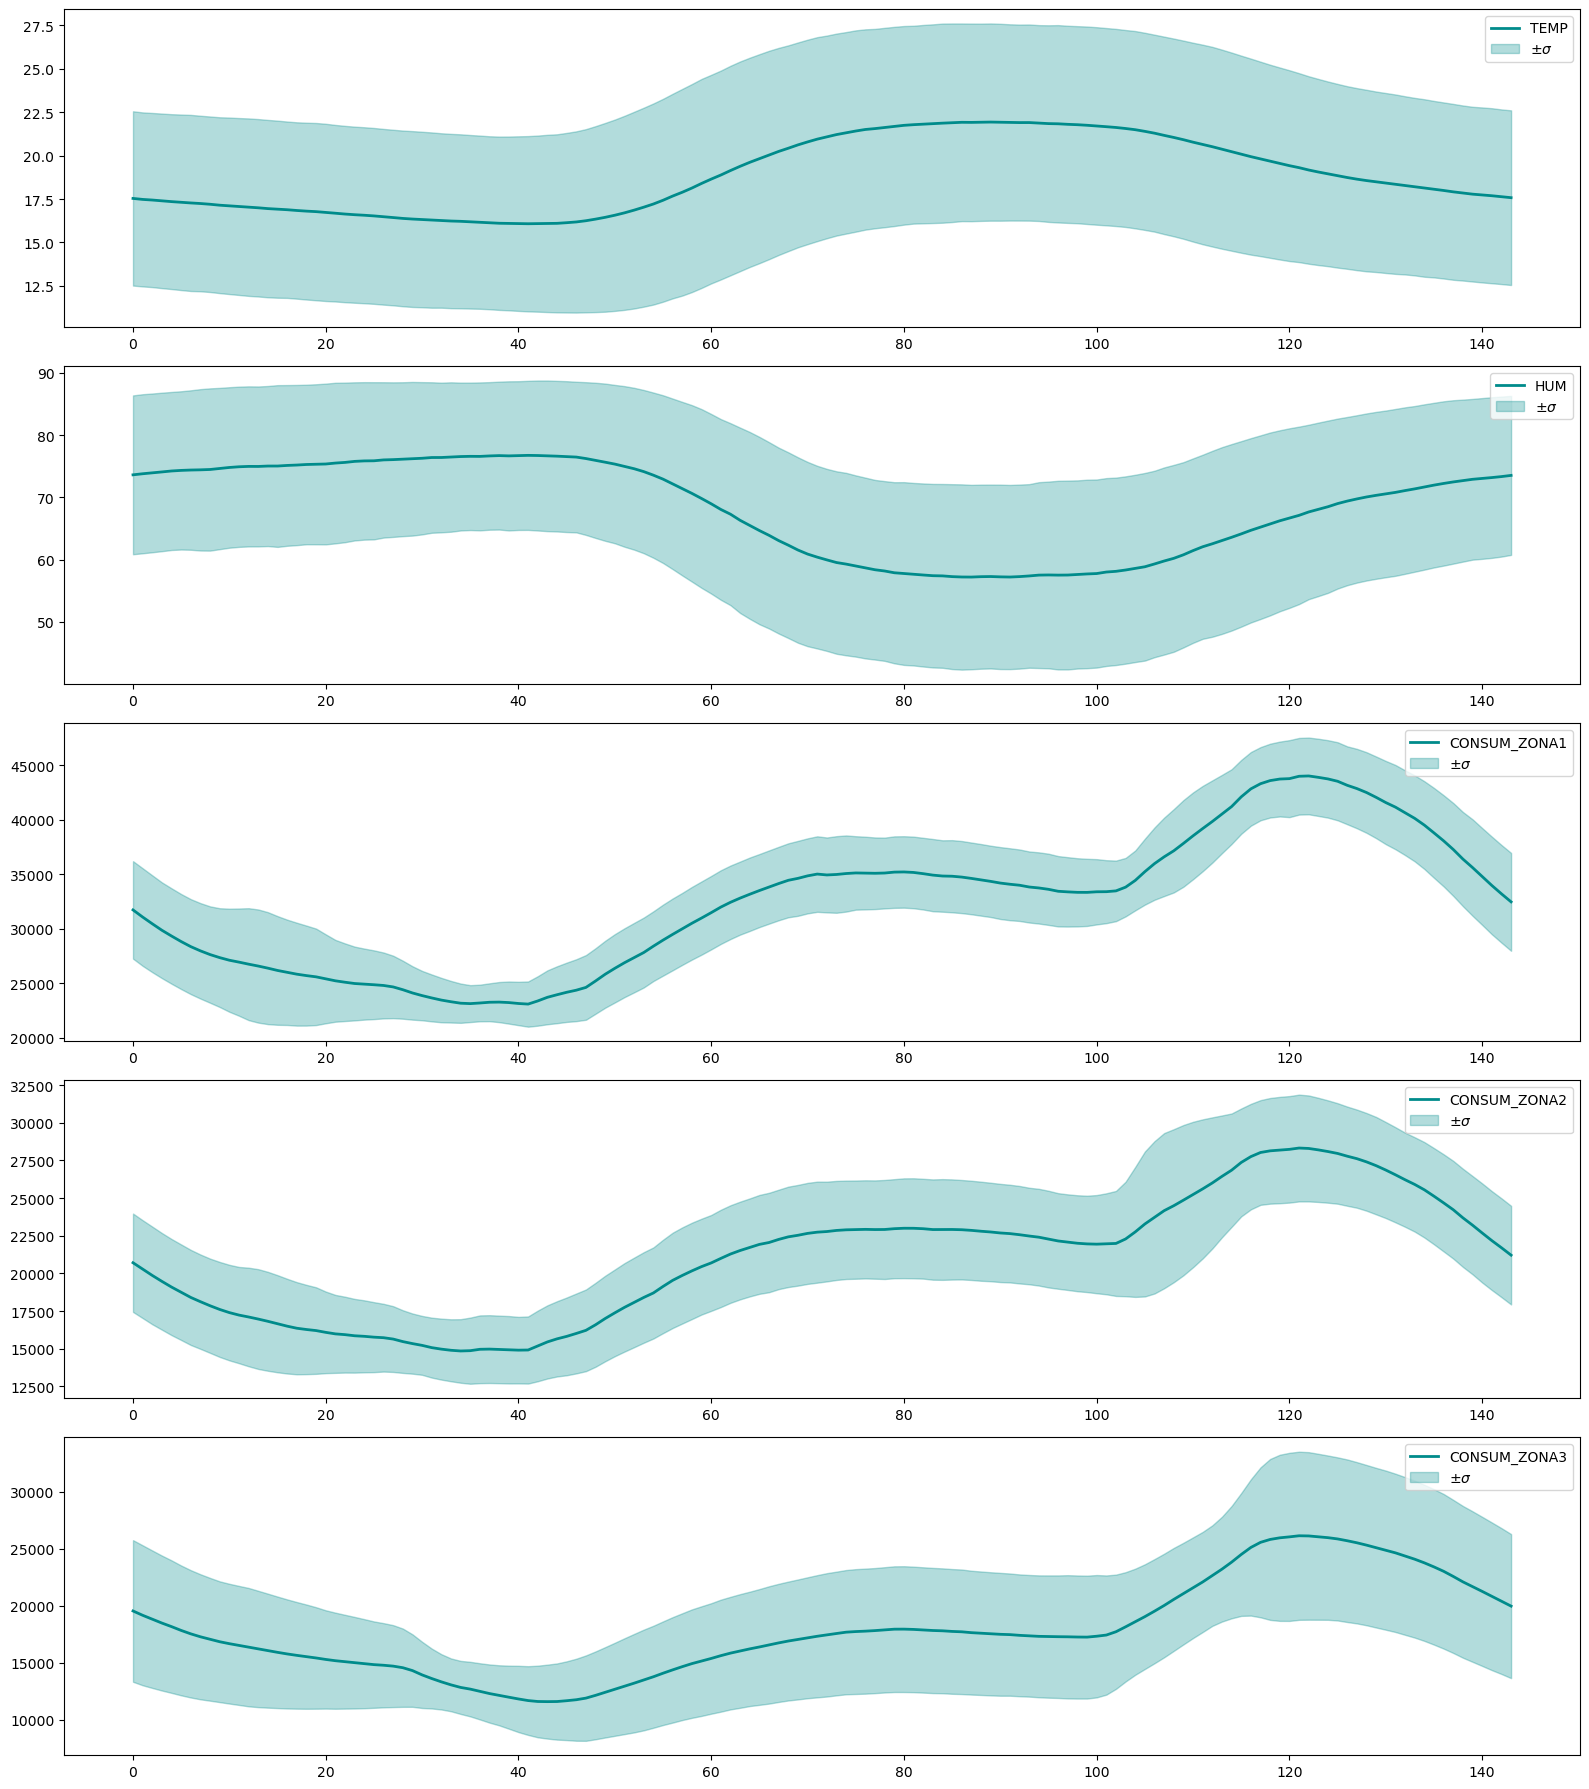

In [32]:
#analizamos la media y la desviacion estandar cada 10 minutos durante 24 hs en el año:
# calculamos la media y la desviacion estandar sobre los dias del año
#para esto vamos a crear un array con filas de 24hs en pasos de 10 min, columnas la cantidad de dias en un año
# y eso para cada variable en el mismo array

arr_datos = []
for i in range(144): 
    arr_datos.append(datos[i::144])
dias_datos = np.array(arr_datos)
#print(arr_datos.shape)

dias_media = dias_datos.mean(axis=1)
dias_std = dias_datos.std(axis=1)

# graficamos la media con su desviacion

fig, axs = plt.subplots(dias_datos.shape[2],1, figsize=(16,18))
for i in range(len(claves)):
    axs[i].plot(dias_media[:,i], label=claves[i], lw = 2, color="darkcyan")
    abajo = dias_media[:,i] - dias_std[:,i]
    arriba = dias_media[:,i] + dias_std[:,i]
    axs[i].fill_between(np.arange(144), abajo, arriba, label='$\pm \sigma$', alpha = 0.3, color="darkcyan")
    axs[i].legend()
fig.tight_layout()


In [31]:
#esto es para mi
print(len(time[143::144]))
print(dias_datos.shape,dias_media.shape)

364
(144, 364, 5) (144, 5)


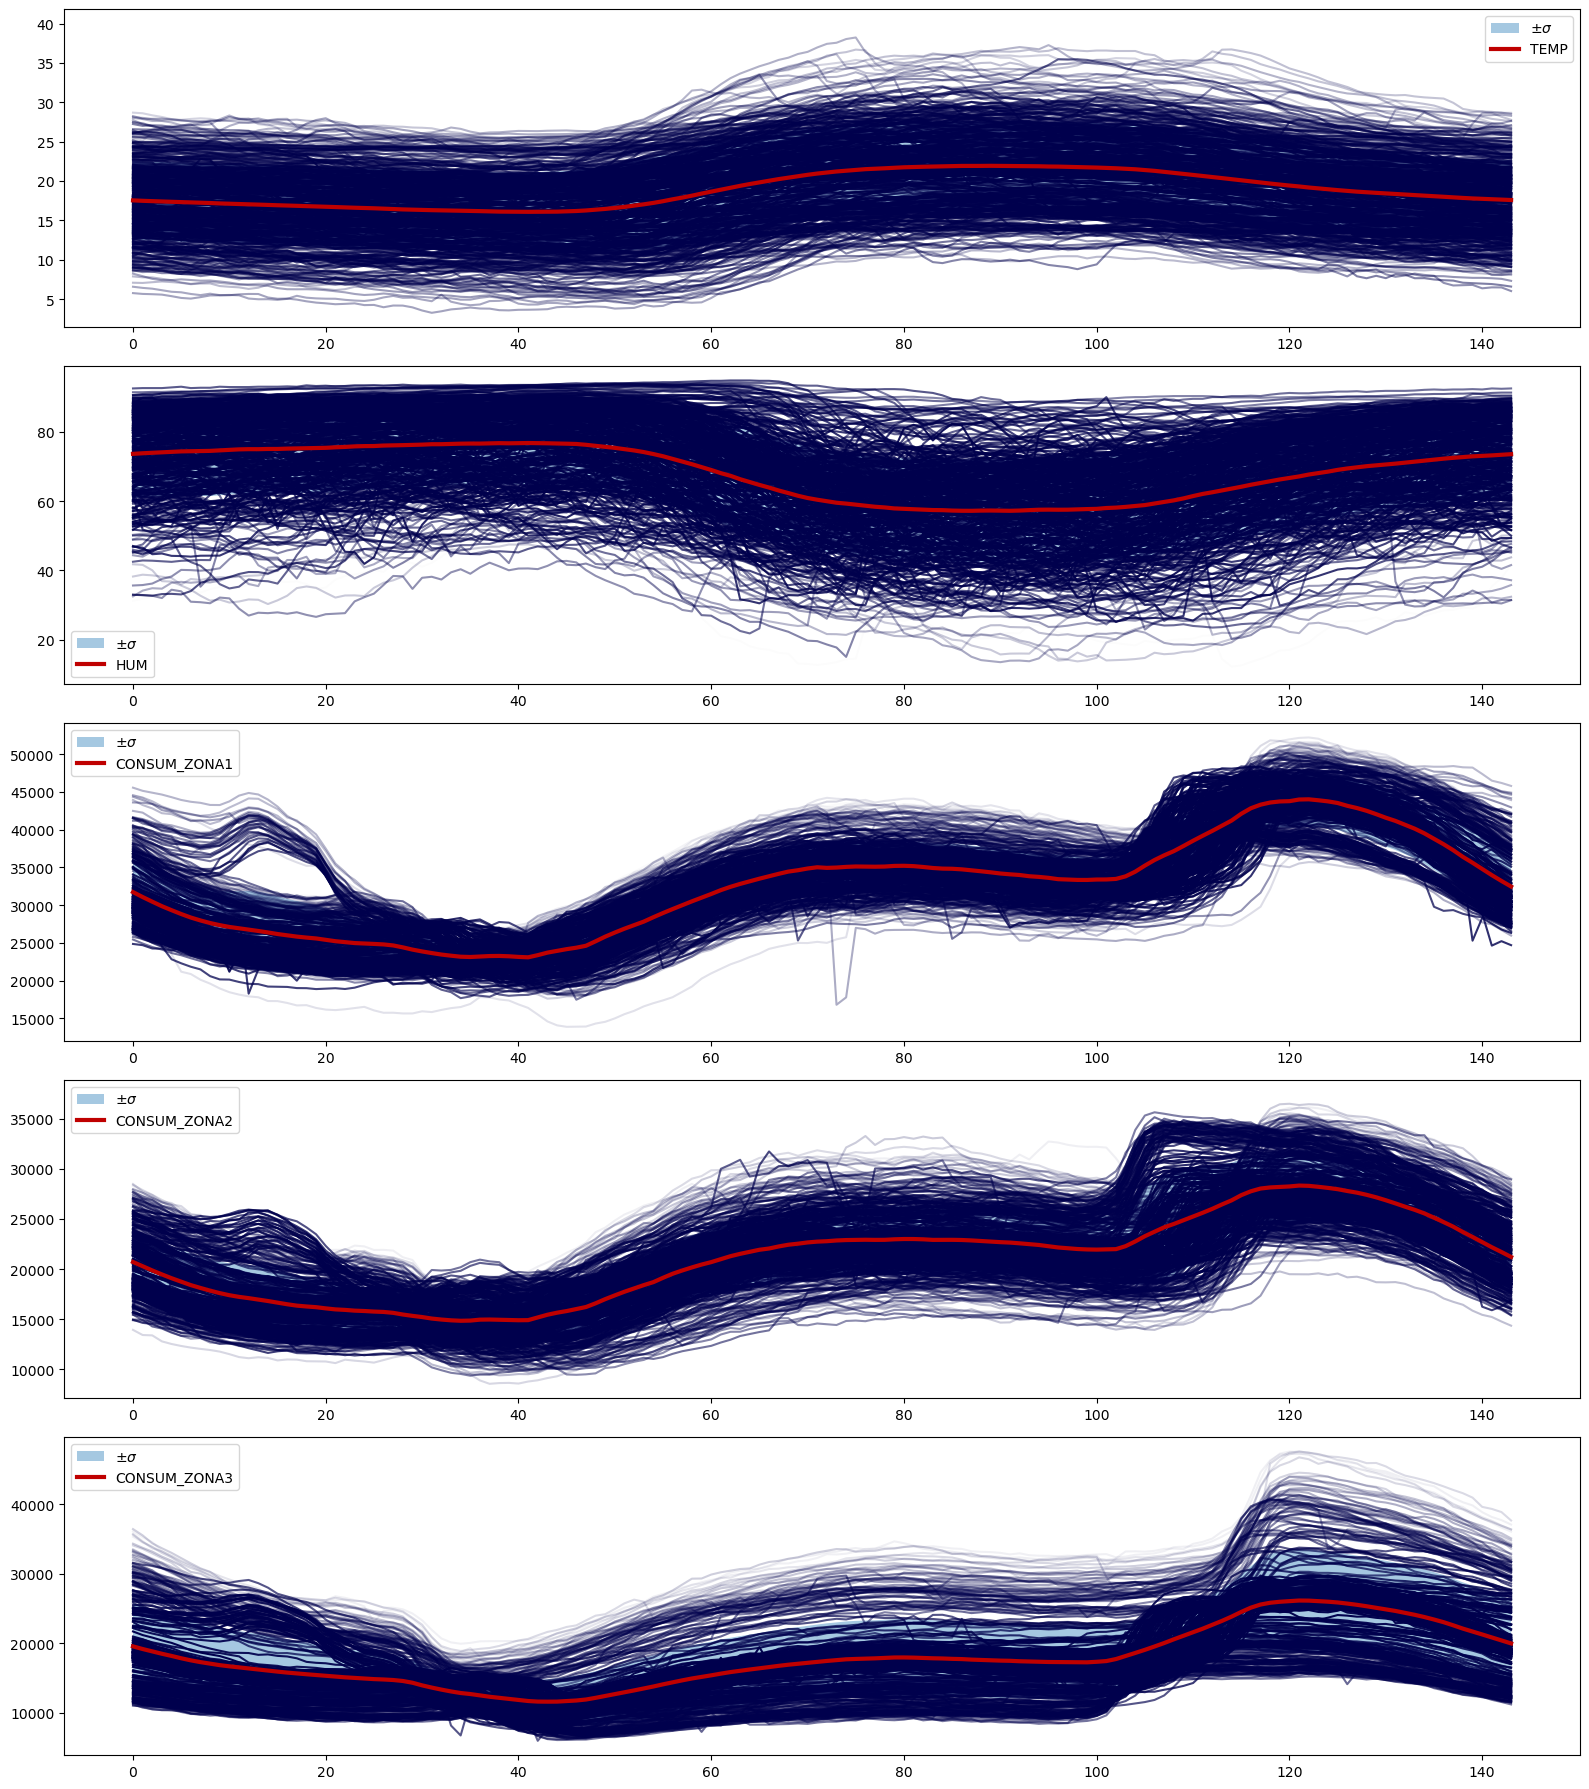

In [33]:
# Podemos ponerle intensidad de colores a cada día según más o menos cerca se encuentre de la media,
# para ello asignamos un coeficiente de todo un día respecto de la media (cef_rM)

def coef_rM(y, y_med):
    return np.abs(y-y_med).mean(axis = 0)

# para cada día calculamos el coeficiente
med_coef = []
for i in range(364):
    med_coef.append(coef_rM(dias_datos[:,i,:], dias_media))
med_coef = (np.array(med_coef)-np.min(med_coef, axis=0) )/(np.max(med_coef, axis=0)-np.min(med_coef, axis=0)) # normalizamos los coeficientes


#reproducimos el grafico anterior para entender que hicimos
fig, axs = plt.subplots(dias_datos.shape[2], 1, figsize=(16,18))
for i in range(len(claves)):
    abajo = dias_media[:,i] - dias_std[:,i]
    arriba = dias_media[:,i] + dias_std[:,i]
    axs[i].fill_between(np.arange(144),abajo, arriba, label='$\pm \sigma$', alpha = 0.4)
    for j in range(364):
        axs[i].plot(dias_datos[:,j,i], color = (0,0,0.3), alpha = 1-med_coef[j,i] )
    axs[i].plot(dias_media[:,i], color = (0.75,0,0), label=claves[i], lw = 3)
    axs[i].legend()
fig.tight_layout()


aqui vemos que hay mucha dispercion comparando dia a dia, vamos a probar mensualemente